In [2]:
import pandas as pd
import numpy as np
import os, zipfile
import matplotlib.pyplot as plt
import dask, time, matplotlib
from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format='retina'

`is_buyer_maker = True` $\rightarrow$ a buyer has taken the ask price $\rightarrow$ `trade_price = ask_price`

## Load and merge all daily HDF dataframe by symbol + save them in parquet

In [31]:
@dask.delayed
def dl(path, file): 
    return pd.read_hdf(path+'/'+file)

In [47]:
symbols = ['ADAUSDT', 'BTCUSDT', 'BNBUSDT', 'DASHUSDT', 'ETHUSDT',
           'LINKUSDT', 'LTCUSDT', 'NANOUSDT', 'THETAUSDT', 'XRPUSDT']

for symbol in symbols:
    path = 'data.nosync/'+symbol
    dfs_promise=[dl(path, file) for file in sorted(os.listdir(path)) if file != '.DS_Store']

    start = time.time()
    dfs=dask.compute(dfs_promise)
    df = pd.concat(dfs[0])
    df.to_parquet(f'data.nosync/_allX/{symbol}.pq')
    
    print('Time to download + merge + save',symbol,':', time.time()-start, 'sec')

Time to download + merge + save NANOUSDT : 26.088258981704712 sec


## Full Data

#### Volume

In [5]:
symbol = 'ADAUSDT'
symb = symbol[:-4]

df = pd.read_parquet('data.nosync/_all/'+symbol+'.pq')
df = df.astype({'volume': 'float', 'price': 'float'})
df = df[df.is_trade_best_price==True]
df.drop(columns='is_trade_best_price', inplace=True)
df

,trade_id,price,volume,first_id,last_id,is_buyer_maker
timestamp,,,,,,
2018-07-25 00:00:00.517,3758510,0.17360,391.5,4171327,4171327,False
2018-07-25 00:00:00.751,3758511,0.17349,749.0,4171328,4171328,True
2018-07-25 00:00:00.811,3758512,0.17349,642.0,4171329,4171329,True
2018-07-25 00:00:01.001,3758513,0.17360,2307.5,4171330,4171330,False
2018-07-25 00:00:01.214,3758514,0.17349,370.6,4171331,4171331,False
...,...,...,...,...,...,...
2021-01-09 23:59:58.351,45531355,0.33062,2653.9,55198747,55198747,False
2021-01-09 23:59:58.351,45531356,0.33063,1041.2,55198748,55198748,False
2021-01-09 23:59:58.715,45531357,0.33043,2611.1,55198749,55198749,True


In [6]:
df_group = df.groupby([df.index.hour, df.index.minute]).count()

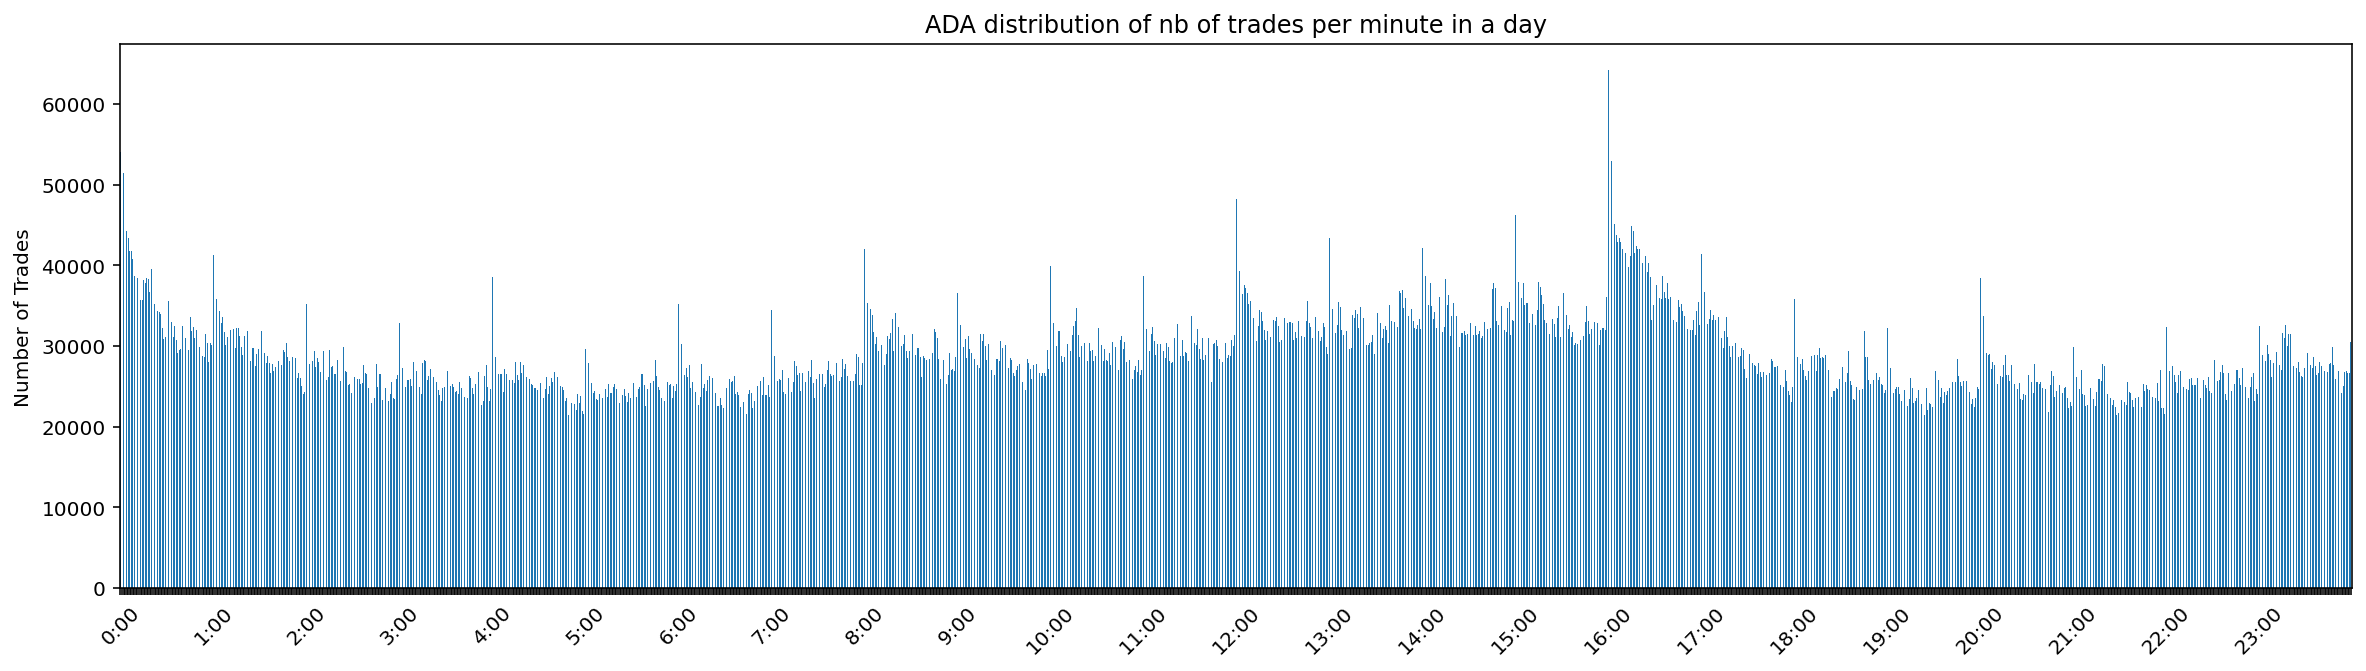

In [7]:
df_group['trade_id'].plot(kind='bar', figsize=(20, 5))
plt.xticks(np.arange(24*60), [str(i//60)+':00' if i%60==0 else '' for i in range(24*60)], rotation=45)
plt.ylabel('Number of Trades')
plt.xlabel('')
title = symb+' distribution of nb of trades per minute in a day'
plt.title(title)
plt.savefig('images/'+title+'.png', dpi=300)
plt.show()

In [8]:
df['usdt_volume']= df.price*df.volume
df_group = df.groupby([df.index.hour, df.index.minute])['usdt_volume'].sum()

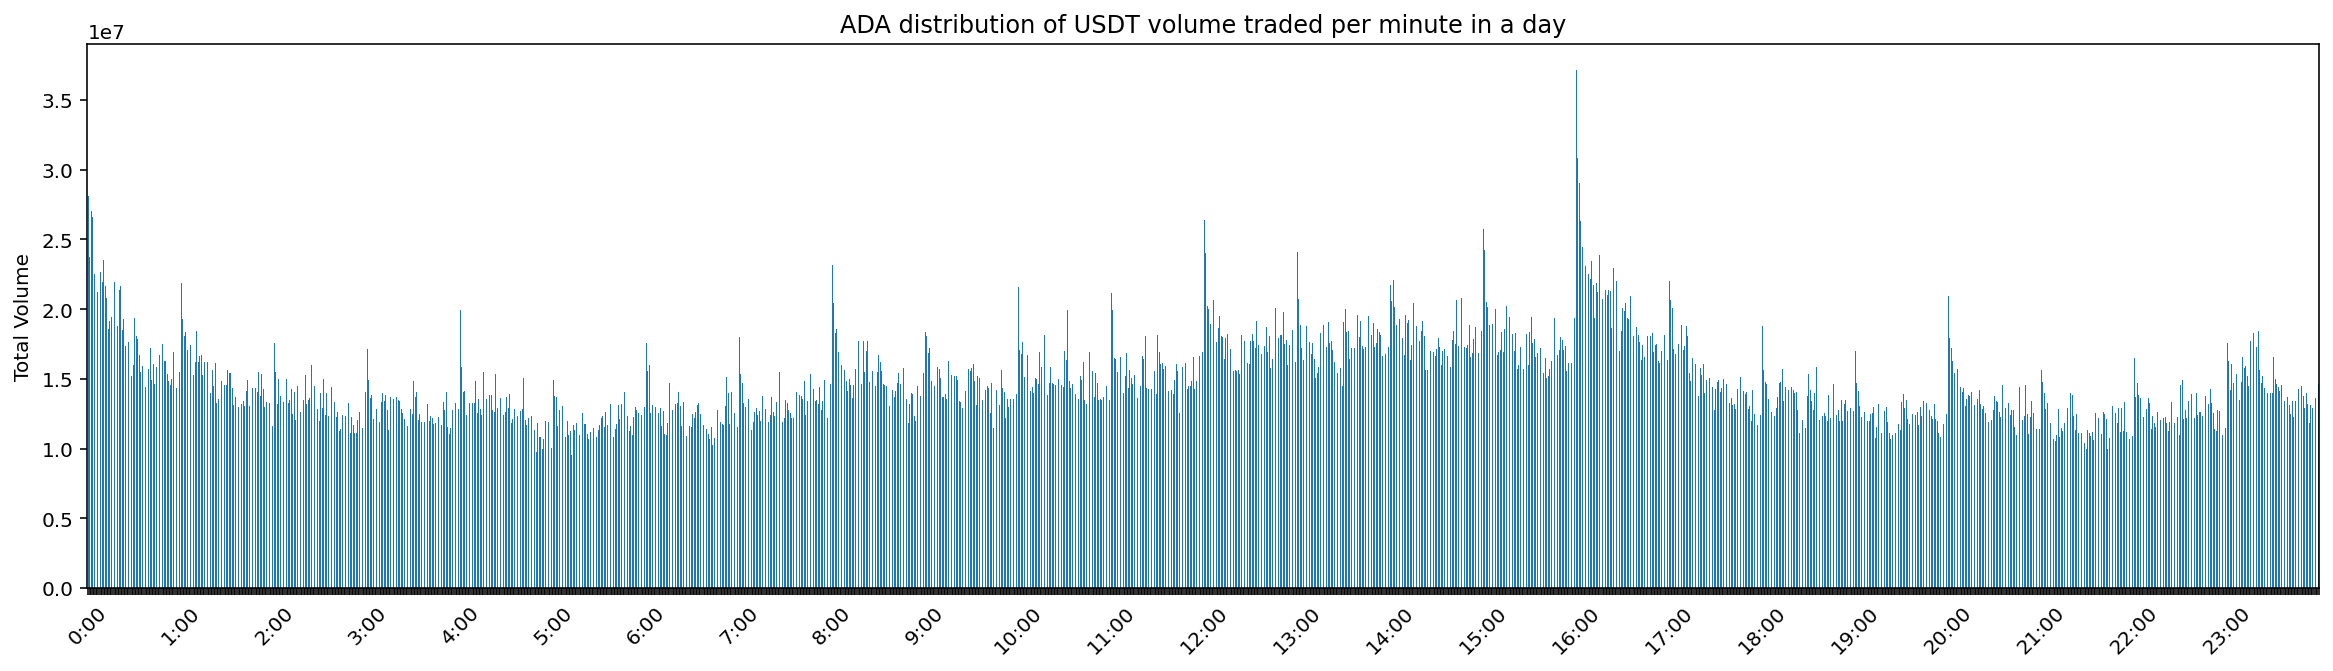

In [9]:
df_group.plot(kind='bar', figsize=(20, 5))
plt.xticks(np.arange(24*60), [str(i//60)+':00' if i%60==0 else '' for i in range(24*60)], rotation=45)
plt.ylabel('Total Volume')
plt.xlabel('')
title = symb+' distribution of USDT volume traded per minute in a day'
plt.title(title)
plt.savefig('images/'+title+'.png', dpi=300)
plt.show()

In [10]:
df_group = df.groupby(pd.Grouper(freq='1Min', origin=0, label='right')).sum()['usdt_volume']

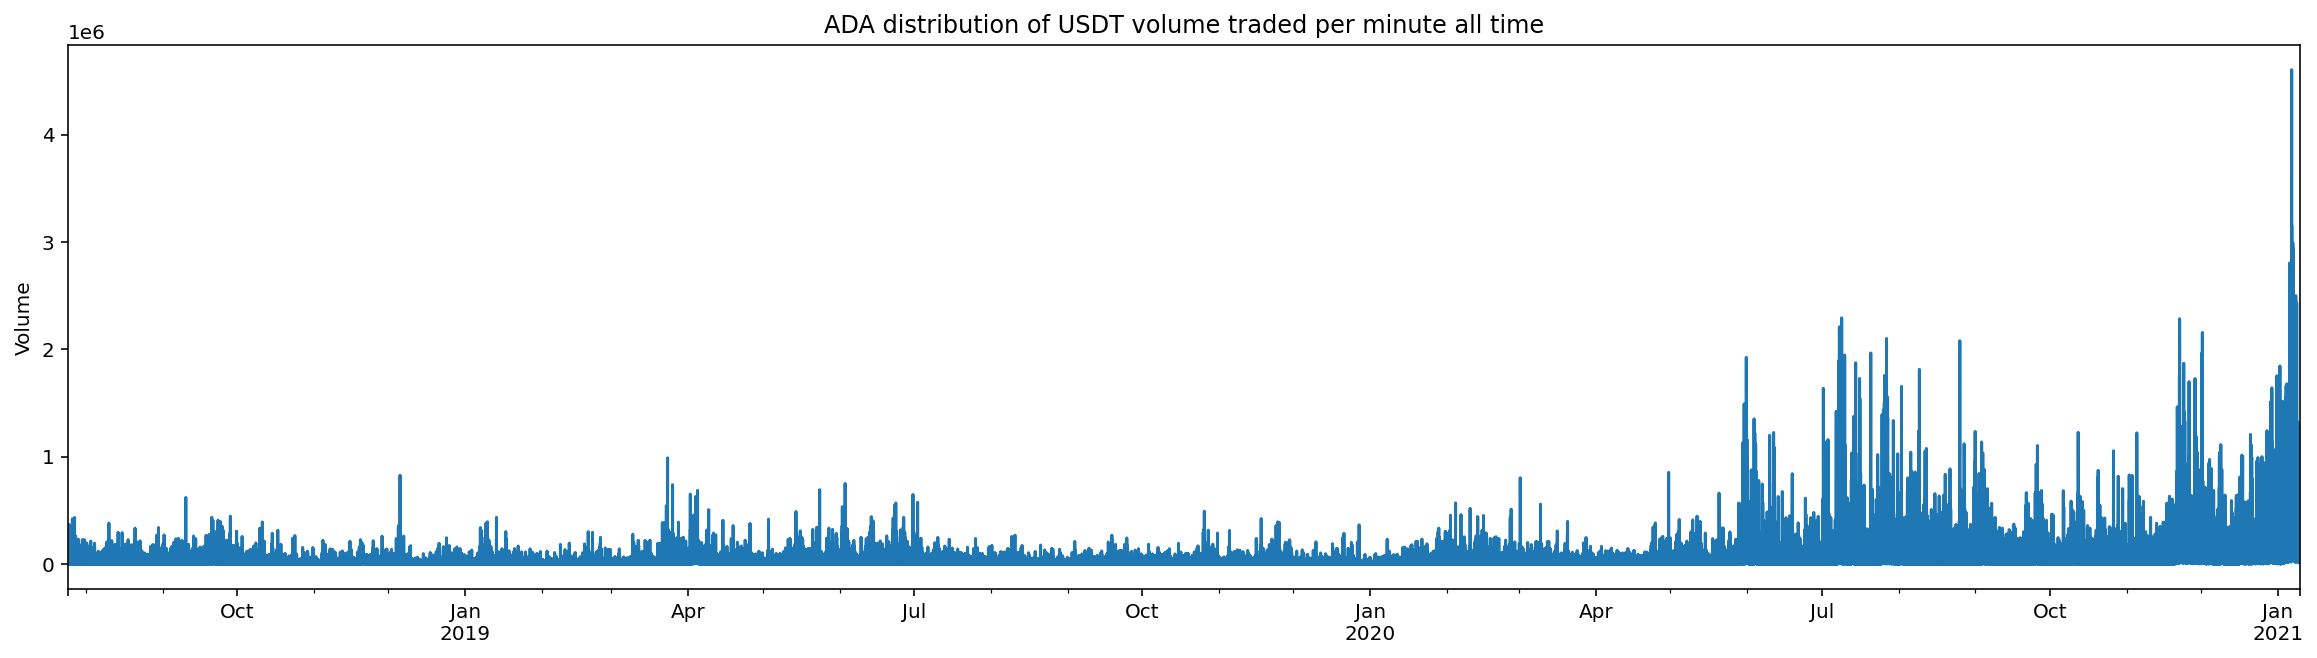

In [11]:
df_group.plot(figsize=(20, 5))
plt.ylabel('Volume')
plt.xlabel('')
title = symb+' distribution of USDT volume traded per minute all time'
plt.title(title)
plt.savefig('images/'+title+'.png', dpi=300)
plt.show()

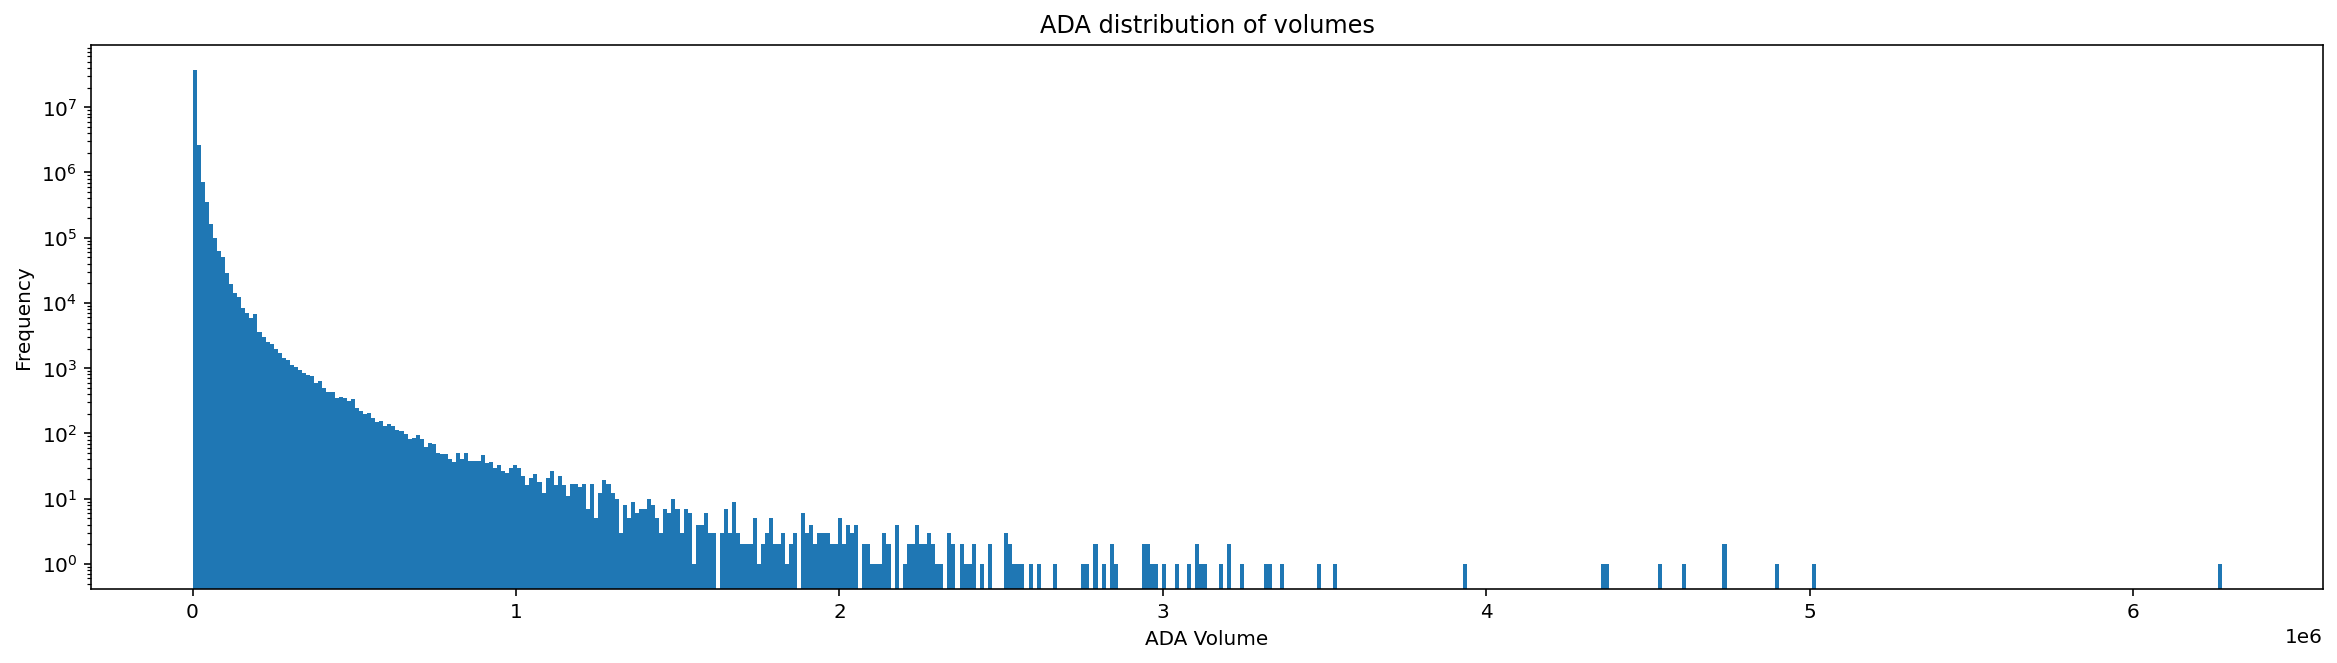

In [12]:
df['volume'].plot(kind='hist', bins=500, log=True, figsize=(20, 5))
plt.xlabel(symb+' Volume')
title = symb+' distribution of volumes'
plt.title(title)
plt.savefig('images/'+title+'.png', dpi=300)

plt.show()

## Aggregated data

In [13]:
df_group = df.groupby([pd.Grouper(freq='30s', origin=0, label='right'),
                             'is_buyer_maker']).agg({'trade_id': ['count'],
                                                     'price': ['min', 'max', 'mean'],
                                                     'volume':'sum'}).reset_index()
df_group.columns = df_group.columns.get_level_values(0)
df_group.index = df_group.timestamp
df_group.drop(columns='timestamp', inplace=True)
df_group.columns = ['is_buyer_maker','nb_trade','min_price','max_price','mid_price','volume_tot']
df_group['mid_price'] = df_group['mid_price'].groupby('timestamp').mean() #group mid_price

df_group.to_parquet(f'data.nosync/_aggreg/{symbol}.pq')
df_group

,is_buyer_maker,nb_trade,min_price,max_price,mid_price,volume_tot
timestamp,,,,,,
2018-07-25 00:00:30,False,24,0.17268,0.17360,0.173046,56897.7
2018-07-25 00:00:30,True,33,0.17264,0.17349,0.173046,49756.8
2018-07-25 00:01:00,False,27,0.17259,0.17315,0.172807,77616.3
2018-07-25 00:01:00,True,24,0.17250,0.17290,0.172807,72612.6
2018-07-25 00:01:30,False,47,0.17315,0.17409,0.173655,185304.6
...,...,...,...,...,...,...
2021-01-09 23:59:00,True,37,0.33038,0.33081,0.330668,127522.4
2021-01-09 23:59:30,False,48,0.32995,0.33069,0.330172,292502.7
2021-01-09 23:59:30,True,59,0.32983,0.33055,0.330172,166762.6


**Compression ratio** $ =\frac{\text{initial number of trades}}{\text{final nb of trades}}$

- ADAUSDT : $\frac{41772850}{3945102} = 10.59$
- BTCUSDT : $\frac{500317769}{6536042} = 76.55$
- BNBUSDT : $\frac{91584907}{5489119} = 16.68$
- DASHUSDT : $\frac{12053267}{1648314} = 7.31$
- ETHUSDT : $\frac{208092931}{6473357} = 32.15$
- LINKUSDT : $\frac{57312498}{2786520} = 20.57$
- LTCUSDT : $\frac{60731167}{5044320} = 12.04$

- NANOUSDT : $\frac{2581072}{575820} = 4.48$
- THETAUSDT : $\frac{9394721}{1082832} = 8.68$
- XRPUSDT : $\frac{101056031}{4813842} = 20.99$


**Time recorded:**

- ADAUSDT :   $\ \ $ 2018-07-25 $\rightarrow$ 2021-01-10
- BTCUSDT :   $\ \ \ $2017-11-24 $\rightarrow$ 2021-01-10
- BNBUSDT :   $\ \ \ $2018-02-13 $\rightarrow$ 2021-01-10
- DASHUSDT :  $\ $2019-07-05 $\rightarrow$ 2021-01-10
- ETHUSDT :   $\ \ \ \ $2017-11-24  $\rightarrow$ 2021-01-10
- LINKUSDT :  $\ \ \ $2019-04-25 $\rightarrow$ 2021-01-10
- LTCUSDT :   $\ \ \ \ \ $2018-03-22 $\rightarrow$ 2021-01-10
- NANOUSDT :  $\ \ $2019-07-11 $\rightarrow$ 2021-01-10
- THETAUSDT : $\ $ 2019-07-18 $\rightarrow$ 2021-01-10
- XRPUSDT :   $\ \ \ \ \ \ $2018-08-11 $\rightarrow$ 2021-01-10


#### Load the aggregated data

In [65]:
symbols = ['ADAUSDT', 'BTCUSDT', 'BNBUSDT', 'DASHUSDT', 'ETHUSDT',
           'LINKUSDT', 'LTCUSDT', 'NANOUSDT', 'THETAUSDT', 'XRPUSDT']
symbs = [symbol[:-4] for symbol in symbols]

@dask.delayed
def load_aggreg(symbol): 
    df = pd.read_parquet('data.nosync/_aggreg/'+symbol+'.pq')
    return df

dfs_promise = [load_aggreg(symbol) for symbol in symbols]

In [66]:
start = time.time()
dfs=dask.compute(dfs_promise)[0]
print('Time to download:', time.time()-start, 'sec')

Time to download: 4.161426782608032 sec


#### Price

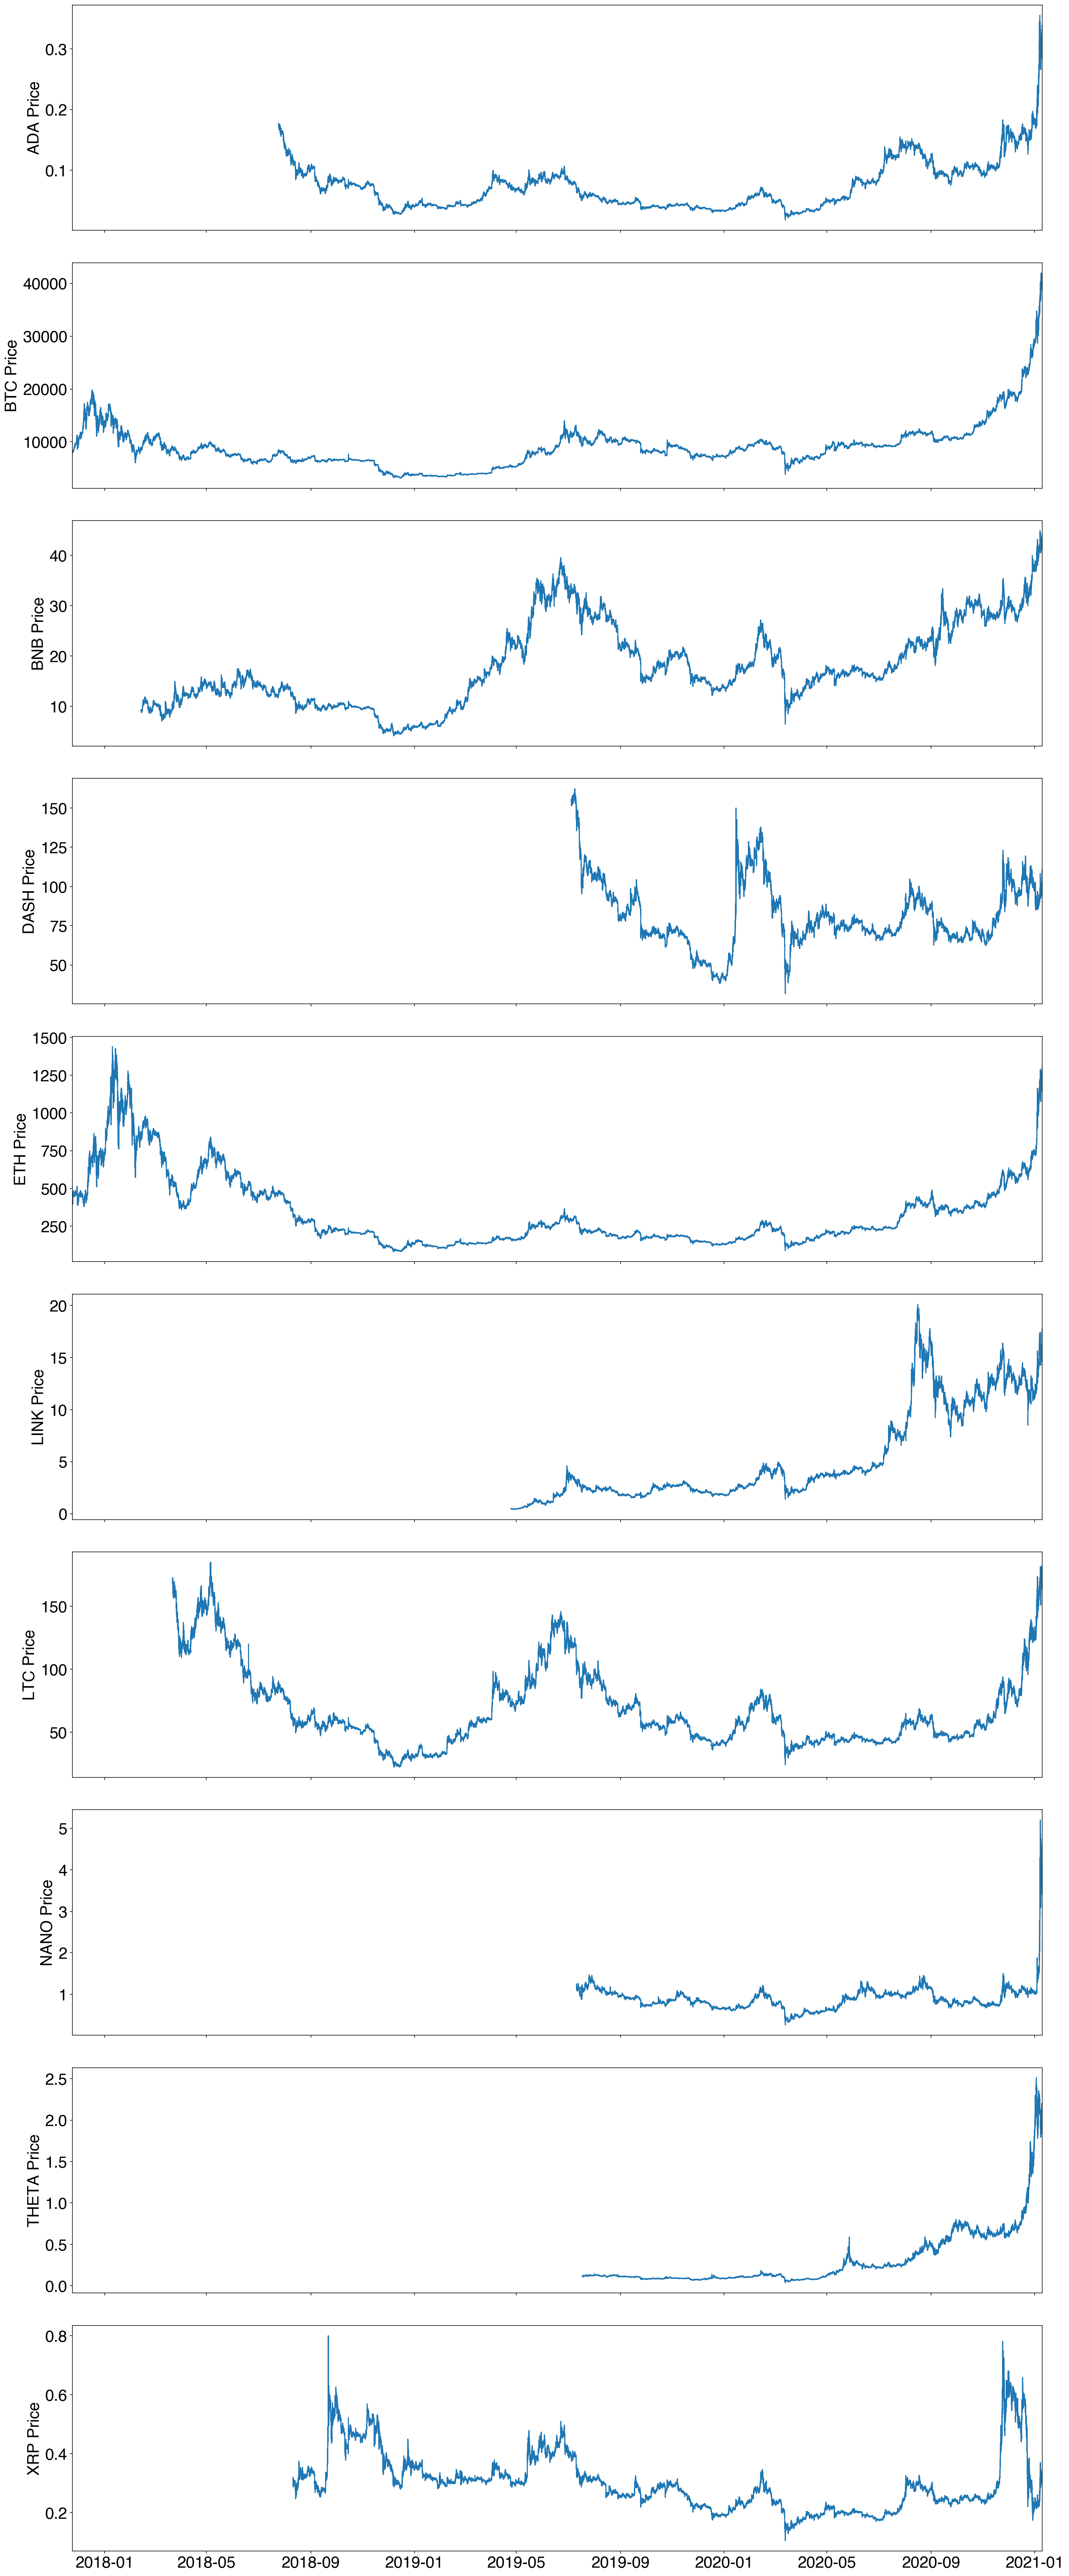

In [79]:
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(20, 50), sharex=True)
fig.tight_layout()

font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)

for i in range(len(axs)):
    axs[i].plot(dfs[i].index, dfs[i]['max_price'])
    axs[i].set_ylabel(symbs[i]+' Price')
    plt.xticks(rotation=0)
    axs[i].set_xlim(datetime(2017,11,24), dfs[i].index[-1])
plt.savefig('images/'+title+'.png', dpi=300, bbox_inches='tight')
plt.show()

#### Spread

In [80]:
# Compute the spread for each asset by taking the spread between the buyer trades' mid-price & seller trades' mid-price
for i in range(len(dfs)):
    dfs[i] = dfs[i]['mid_price'].groupby('timestamp').apply(lambda x : x[0] - x[-1] if x[0]!=x[-1] else None).ffill()

KeyboardInterrupt: 

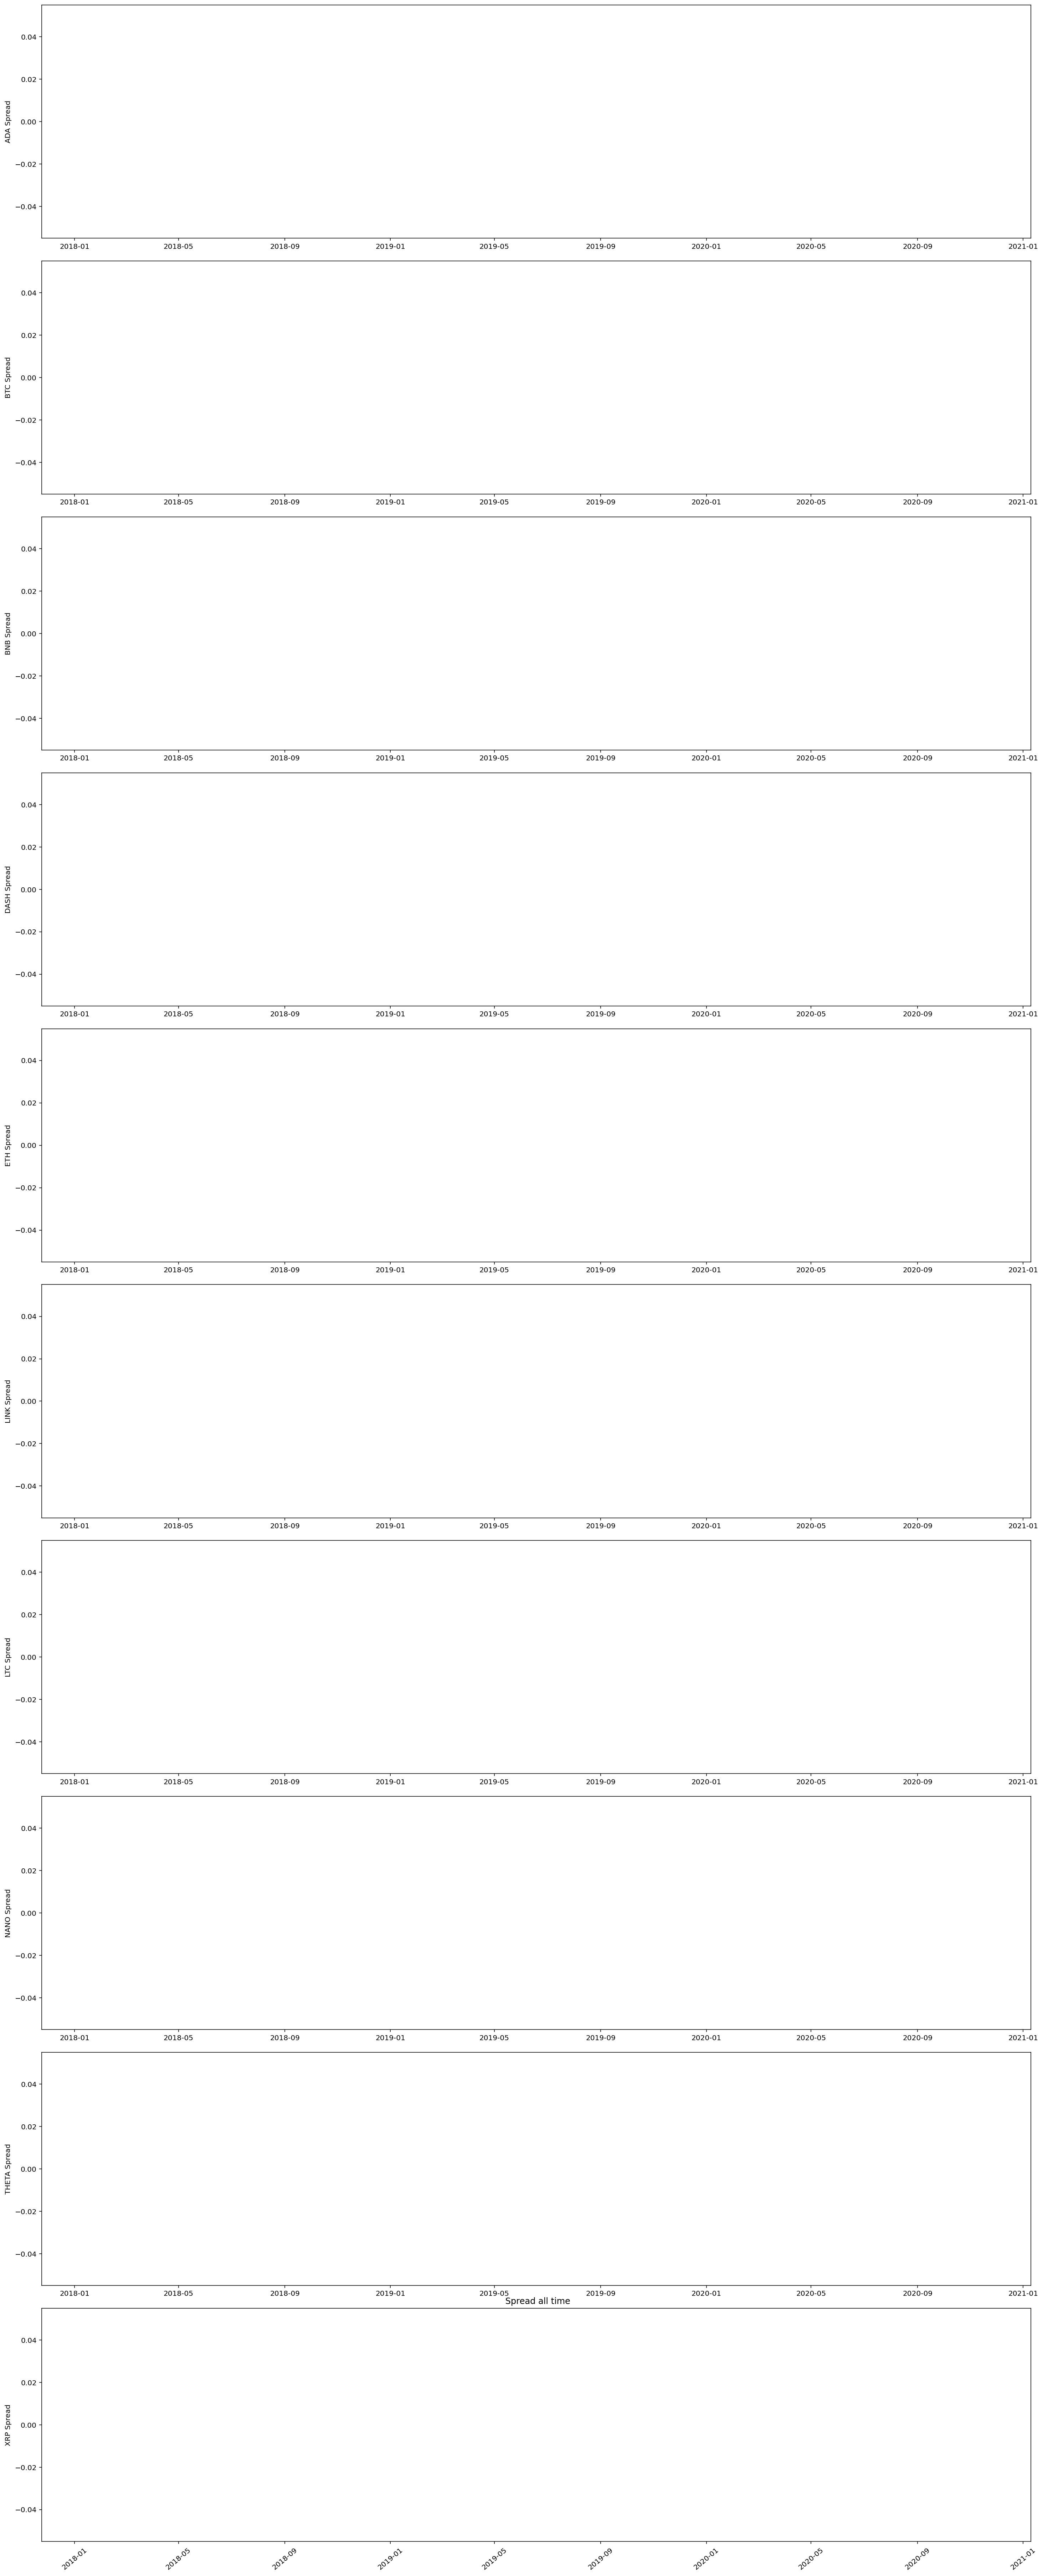

In [60]:
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(20, 50))
fig.tight_layout()

for i in range(len(axs)):
    axs[i].plot(dfs[i].index, dfs[i].values)
    axs[i].set_ylabel(symbs[i]+' Spread')
    plt.xticks(rotation=40)
    axs[i].set_xlim(datetime(2017,11,24), dfs[i].index[-1])
title = ' Spread all time'
plt.title(title)
plt.savefig('images/'+title+'.png', dpi=300)
plt.show()

We can see that sometimes the spread is negative. This is due to the fact that we have estimated the ask and bid price of assets by taking the average of buyer-initiated trades and seller-initiated trades respectively. It happens that sometimes, over the chosen time interval (30s), the average trade-price of buyer-initiated trades is smaller than the one corresponding to the seller-initiated trades. 

To counter this problem, we can compute the spread for each cryptocurrency by taking the spread between the min price of the buyer trades & max price of seller trades

In [61]:
# Reload data into dfs
for symbol in symbols:
    symbs.append(symbol[:-4])
    dfs.append(pd.read_parquet('data.nosync/_aggreg/'+symbol+'.pq'))

In [62]:
# Compute the spread for each asset by taking the spread between the min of buyer trades & max of seller trades
for i in range(len(dfs)):
    dfs[i] = dfs[i][['min_price','max_price']].groupby('timestamp').apply(lambda x : x.iloc[0].max_price - x.iloc[-1].min_price if x.iloc[0].max_price!=x.iloc[-1].max_price else None).ffill()

KeyError: "None of [Index(['min_price', 'max_price'], dtype='object', name='timestamp')] are in the [index]"

In [ ]:
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(20, 50))
fig.tight_layout()

for i in range(len(axs)):
    axs[i].plot(dfs[i].index, dfs[i].values)
    axs[i].set_ylabel(symbs[i]+' Spread')
    plt.xticks(rotation=40)
    axs[i].set_xlim(datetime(2017,11,24), dfs[i].index[-1])
title = ' Spread all time v2'
plt.suptitle(title)
plt.savefig('images/'+title+'.png', dpi=300)
plt.show()